In [99]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random

import albumentations
import albumentations.pytorch

In [100]:
!pip3 install quickdraw

In [101]:
from quickdraw import QuickDrawData, QuickDrawDataGroup

In [102]:
seed = 111

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [103]:
num_img_per_class = 3000

qd = QuickDrawData(max_drawings=num_img_per_class)

class_list = ['apple', 
              'wine bottle', 
              'spoon', 
              'rainbow', 
              'panda', 
              'hospital', 
              'scissors', 
              'toothpaste', 
              'baseball', 
              'hourglass']

class_dict = {'apple' : 0, 
              'wine bottle' : 1, 
              'spoon' : 2, 
              'rainbow' : 3, 
              'panda': 4, 
              'hospital' : 5, 
              'scissors' : 6, 
              'toothpaste' : 7, 
              'baseball' : 8, 
              'hourglass' : 9}

In [104]:
qd.load_drawings(class_list)

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [105]:
train_data = []
val_data = []

train_label = []
val_label = []

for class_name in class_list:
    qdgroup = QuickDrawDataGroup(class_name,
                                 max_drawings=num_img_per_class)
    
    for i, img in enumerate(qdgroup.drawings):
        if i<int(0.9*num_img_per_class):
            train_data.append(img.get_image())
            train_label.append(class_dict[class_name])
        else:
            val_data.append(img.get_image())
            val_label.append(class_dict[class_name])

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [106]:
class QuickDrawDataset(Dataset):

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img = self.data[idx]
        
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [107]:
transform = transforms.Compose([
    transforms.RandomAdjustSharpness(sharpness_factor=0),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=5),
    transforms.RandomCrop(230), # 255 -> 230
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
    # ImageNet의 mean과 std로, 통상적으로 normalize 수행할 때 사용함
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
])

In [108]:
i = next(iter(train_data))
t = transforms.ToTensor()(i)
t.shape

torch.Size([3, 255, 255])

In [109]:
qd_train_dataset = QuickDrawDataset(train_data, train_label, transform)
qd_val_dataset = QuickDrawDataset(val_data, val_label, transform_val)

qd_train_dataloader = DataLoader(qd_train_dataset, batch_size=64, shuffle=True)
qd_val_dataloader = DataLoader(qd_val_dataset, batch_size=64, shuffle=True)

# Visualizing augmented images
- Channel order:
  - cv2: BGR
  - torch: RGB
- Dimension:
  - cv2: (height, width, channel)
  - torch conv2d layer: (batch_size, channel, height, width)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


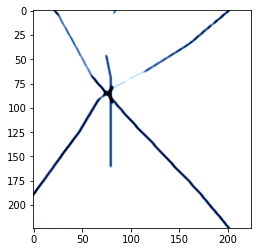

torch.Size([3, 224, 224])
tensor(9)


In [110]:
img, label = next(iter(qd_train_dataloader))

plt.imshow(img[0].permute(1, 2, 0)) # torch.permute: dimension swapping
plt.show()
print(img[0].shape)
print(label[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


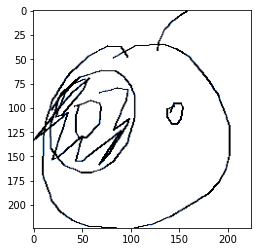

torch.Size([3, 224, 224])
tensor(4)


In [111]:
val_img, val_label = next(iter(qd_val_dataloader))

plt.imshow(val_img[0].permute(1, 2, 0))
plt.show()
print(val_img[0].shape)
print(val_label[0])

# Training VGG-11 with augmented images

In [112]:
from torchvision.models import vgg11

pretrained=True

model = vgg11(pretrained)

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [113]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [114]:
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [115]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(model.parameters(), lr=1e-4)

In [116]:
log_dir = './log'

os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'augmentation_train_log.csv'), 'w') as log:

    model.train()

    for iteration, (img, label) in enumerate(qd_train_dataloader):

        optimizer_ft.zero_grad()

        img, label = img.float().cuda(), label.long().cuda()

        pred_logit = model(img)

        loss = criterion(pred_logit, label)

        loss.backward()
        optimizer_ft.step()

        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label==label).sum().item() / len(img)

        train_loss = loss.item()
        train_acc = acc

        if (iteration%20==0) or (iteration==len(qd_train_dataloader)-1):
            
            model.eval()

            valid_loss, valid_acc = AverageMeter(), AverageMeter()

            for img, label in qd_val_dataloader:

                img, label = img.float().cuda(), label.long().cuda()

                with torch.no_grad():
                    pred_logit = model(img)

                loss = criterion(pred_logit, label)

                pred_label = torch.argmax(pred_logit, 1)
                acc = (pred_label==label).sum().item() / len(img)

                valid_loss.update(loss.item(), len(img))
                valid_acc.update(acc, len(img))

            valid_loss = valid_loss.avg
            valid_acc = valid_acc.avg

            print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iteration, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
            log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iteration, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/422] | Train Loss 2.4141 | Train Acc 0.0312 | Valid Loss 2.2524 | Valid Acc 0.1527
Iter [ 20/422] | Train Loss 0.8858 | Train Acc 0.7188 | Valid Loss 0.6415 | Valid Acc 0.8057
Iter [ 40/422] | Train Loss 0.5034 | Train Acc 0.8281 | Valid Loss 0.5071 | Valid Acc 0.8483
Iter [ 60/422] | Train Loss 0.3440 | Train Acc 0.8594 | Valid Loss 0.4135 | Valid Acc 0.8733
Iter [ 80/422] | Train Loss 0.4112 | Train Acc 0.8906 | Valid Loss 0.3919 | Valid Acc 0.8920
Iter [100/422] | Train Loss 0.4681 | Train Acc 0.8594 | Valid Loss 0.3597 | Valid Acc 0.8970
Iter [120/422] | Train Loss 0.3661 | Train Acc 0.8594 | Valid Loss 0.3440 | Valid Acc 0.8927
Iter [140/422] | Train Loss 0.4483 | Train Acc 0.8594 | Valid Loss 0.2932 | Valid Acc 0.9100
Iter [160/422] | Train Loss 0.3985 | Train Acc 0.8594 | Valid Loss 0.3245 | Valid Acc 0.9090
Iter [180/422] | Train Loss 0.3138 | Train Acc 0.8438 | Valid Loss 0.3376 | Valid Acc 0.8983
Iter [200/422] | Train Loss 0.2265 | Train Acc 0.9531 | Valid Loss 0.2

In [117]:
augmentation_train_log = pd.read_csv(os.path.join(log_dir, 'augmentation_train_log.csv'), index_col=0, header=None)

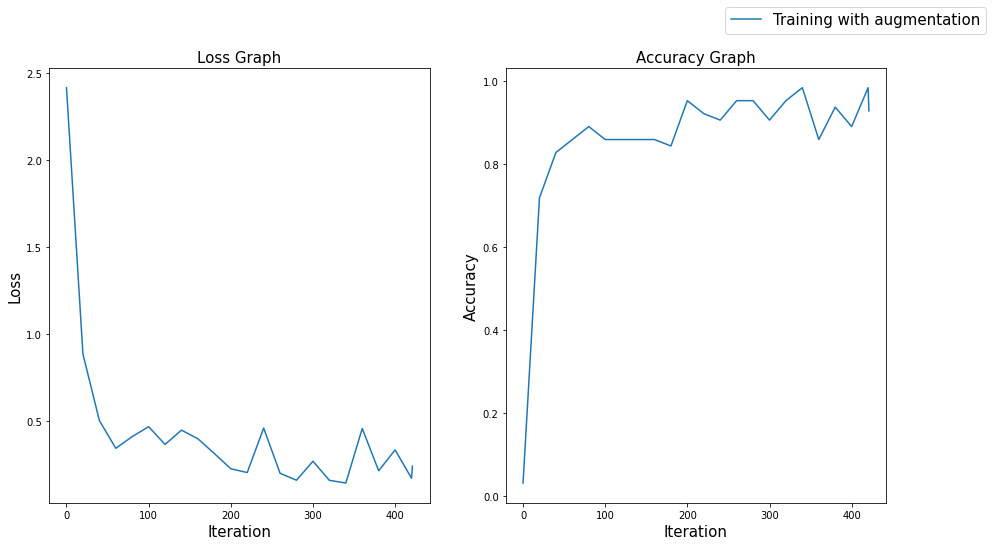

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(augmentation_train_log.iloc[:,0], label='Training with augmentation')
ax1.set_title('Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(augmentation_train_log.iloc[:,1], label='Training with augmentation')
ax2.set_title('Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()